In [1]:
# Import libraries
import numpy as np
import math  
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.fft import fft, fftfreq, fftshift

In [2]:
def Pfire(lamba , lamba_old, dt = 0.001):
    p_lamba = (lamba + lamba_old)*dt / 2 

    if p_lamba > 0.01: 
        p_lamba = 1 - np.exp(-p_lamba)
    return p_lamba

In [3]:
def mesoscopic_single_population( input_drive  , sim_dur = 0.3 , N = 2_00,  transfer_func = 'expo' ,  J = 0 ,  tau_m = 0.02  , dt = 0.001): 


    # Check whether input drive is defined for all "grid" points of the simulation 

    if len(input_drive) != math.ceil(sim_dur / dt ) : 
        raise Exception("Input drive does not match simulation duration") 

    T = math.floor(5*tau_m / dt  ) + 1 
    x , z , h = 0.0 , 0.0, 0.0
    n = np.array( [0.]*T )                                   # Spike count array
    n[-1]  =  1.0          
    S = np.array( [1.0]*T )                                   # Survival probability
    u = np.array( [0.0]*T )                                   # Membrane potential array 

    

    del_u = 0.001          # mV
    theta = 0.01             # mV
    c  = 10.0 

    if transfer_func == 'tanh':
        def f_func(x):
            return 1 / ( 1 + np.exp(-x))
    elif  transfer_func == 'expo' :
        def f_func(x):
            return c*np.exp( ( x - theta )  / del_u )
    else  :
        def f_func(x):
        
            return None  
        
        raise Exception("Transfer function method not defined")

    lamba_free      = f_func(0.0)                                                 # intensity rate or hazard rate at the free membrane potential of reset? 
    A               = np.zeros([ math.ceil(sim_dur / dt) + 1  ])
    A[0]            =  1 / dt 
    A_mean          = np.zeros([ math.ceil(sim_dur / dt) + 1  ])
    A_mean[0]       = 1 / dt                                                    #  not sure about this??? 
    for t in range(1, math.ceil ( sim_dur /  dt )   ): 

        h = h  + (  (  input_drive[t]  - h  ) / tau_m   + J*A[t-1]    )*dt      # Equation for the free membrane potential 
        P_lamba = Pfire( f_func(h) , f_func(0.0) , dt = dt )                     # Update P_lamba
        W , X , Y , Z = P_lamba*x , x ,  P_lamba , z 
        x = x - W         
        z = (1 - P_lamba)*(1-P_lamba)*z + W 
        
        

        for  r in range(1, T):
            u[r-1] = u[r] + ( (  input_drive[t] - u[r] ) / tau_m + J*A[t-1]   )*dt 
            P_lamba = Pfire( f_func(u[r-1]) , f_func( u[r])  , dt = dt  )           


            m = S[r]*n[r]
            v = (1 - S[r])*m
            W = W + P_lamba*m
            X = X + m
            Y = Y + P_lamba*v
            Z = Z + v 
            S[r-1] = (1- P_lamba)*S[r]
            n[r-1] = n[r] 
            

        x = x + S[0]*n[0]
        z = z + (1.0-S[0])*S[0]*n[0]        

        if Z > 0.0: 
            P_big_lamba = Y / Z
        else :
            P_big_lamba = 0.0      

        
        n_mean = min(max (  0.0, W + P_big_lamba*(1-X)  ) , 1.0 )
        

        n[-1] = np.random.binomial(N, n_mean, 1 ) / N 
        
        
        
        A_mean[t]  = n_mean / dt 
        A[t]       = n[-1] / dt    


    return A , A_mean , u ,  S 

In [4]:
# Run simulation 
# print(len(constant_input_drive))

def simulation_plotter(coupling_param = 0 , num_sim_param = 200 , sim_dur_param = 1.0 , dt_param = 0.001 , drive_amp_param = 0.02 , sine = False , freq = 10 ):
    
    num_sim  = num_sim_param 
    sim_dur = sim_dur_param 
    dt =  dt_param 
    drive_amp = drive_amp_param # mV
    J = coupling_param 

    
    time_arr = np.arange(0, sim_dur, dt)

    if sine :
        input_drive =  np.array( drive_amp_param*np.sin( freq * time_arr)  )
    else:
        input_drive =  np.array( [drive_amp]* math.ceil(sim_dur /dt) )
    
    
   

    
    A_avg      = np.zeros([ math.ceil(sim_dur / dt) + 1  ]) 
    A_mean_avg = np.zeros([ math.ceil(sim_dur / dt) + 1  ])


    for idx in range(num_sim): 
        A , A_mean , u ,  S  =  mesoscopic_single_population( input_drive,  J = J ,  sim_dur = sim_dur, dt = dt) 

        A_avg += A / num_sim 
        A_mean_avg += A_mean / num_sim 


    return A_avg, A_mean_avg , time_arr, input_drive 




# Constant Input Drive

## $J = 0 $

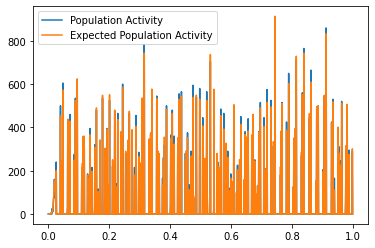

In [5]:
A_avg, A_mean_avg , time_arr , input_drive  = simulation_plotter(coupling_param = 0, num_sim_param = 1) 

# Plot Mesoscopic Activity


plt.plot(time_arr , A_avg[1:],   label = 'Population Activity')
plt.plot(time_arr ,  A_mean_avg[1:],       label = 'Expected Population Activity')
plt.legend()
plt.show()

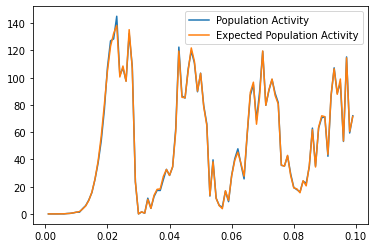

In [8]:
A_avg, A_mean_avg , time_arr , input_drive  = simulation_plotter(coupling_param = 0, num_sim_param = 100) 

# Plot Mesoscopic Activity


plt.plot(time_arr[1:100] , A_avg[1:100],   label = 'Population Activity')
plt.plot(time_arr [1:100],  A_mean_avg[1:100],       label = 'Expected Population Activity')
plt.legend()
plt.show()

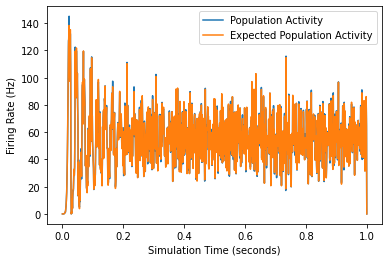

In [12]:
plt.plot(time_arr[:] , A_avg[1:],   label = 'Population Activity')
plt.plot(time_arr [:],  A_mean_avg[1:],       label = 'Expected Population Activity')
plt.xlabel('Simulation Time (seconds)')
plt.ylabel('Firing Rate (Hz)')
plt.legend()
plt.show()

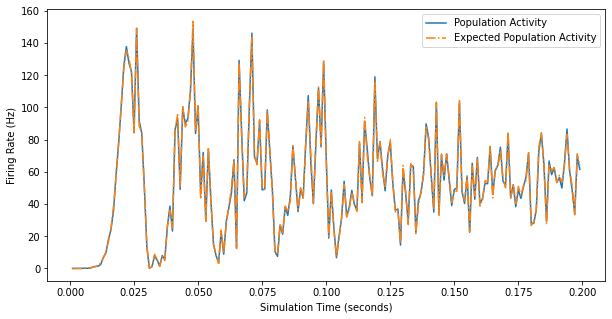

In [31]:
plt.rcParams['figure.figsize']  = (10,5)
plt.plot(time_arr[1:200] , A_avg[1:200],   label = 'Population Activity' )
plt.plot(time_arr [1:200],  A_mean_avg[1:200],       label = 'Expected Population Activity', ls = '-.')
plt.xlabel('Simulation Time (seconds)')
plt.ylabel('Firing Rate (Hz)')
plt.legend()
plt.show()

## J > 0 

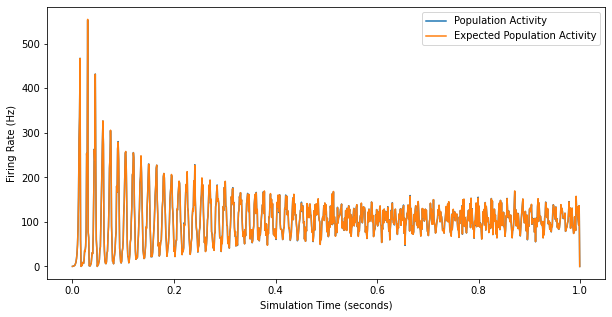

In [32]:
A_avg, A_mean_avg , time_arr , input_drive = simulation_plotter(coupling_param = 0.005) 

# Plot Mesoscopic Activity

plt.plot(time_arr , A_avg[1:],  label = 'Population Activity')
plt.plot(time_arr ,  A_mean_avg[1:],   label = 'Expected Population Activity')
plt.xlabel('Simulation Time (seconds)')
plt.ylabel('Firing Rate (Hz)')
plt.legend()
plt.show()

## J < 0 

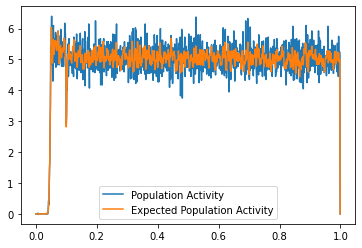

In [ ]:
A_avg, A_mean_avg , time_arr , input_drive  = simulation_plotter(coupling_param = -0.1) 

# Plot Mesoscopic Activity

plt.plot(time_arr , A_avg[1:],  label = 'Population Activity')
plt.plot(time_arr ,  A_mean_avg[1:],   label = 'Expected Population Activity')
plt.legend()
plt.show()

## $J < 0 $, Stronger Drive

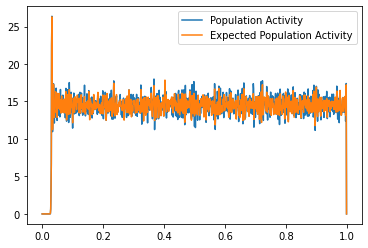

In [ ]:
A_avg, A_mean_avg , time_arr , input_drive  = simulation_plotter(coupling_param = -0.1, drive_amp_param = 0.04) 

# Plot Mesoscopic Activity

plt.plot(time_arr , A_avg[1:],  label = 'Population Activity')
plt.plot(time_arr ,  A_mean_avg[1:],   label = 'Expected Population Activity')
plt.legend()
plt.show()

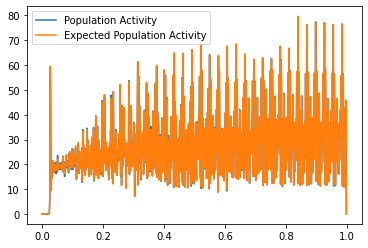

In [ ]:
A_avg, A_mean_avg , time_arr  , input_drive = simulation_plotter(coupling_param = -0.1, drive_amp_param = 0.05) 

# Plot Mesoscopic Activity

plt.plot(time_arr , A_avg[1:],  label = 'Population Activity')
plt.plot(time_arr ,  A_mean_avg[1:],   label = 'Expected Population Activity')
plt.legend()
plt.show()

# Sinusoidal Input 

## $ J = 0$

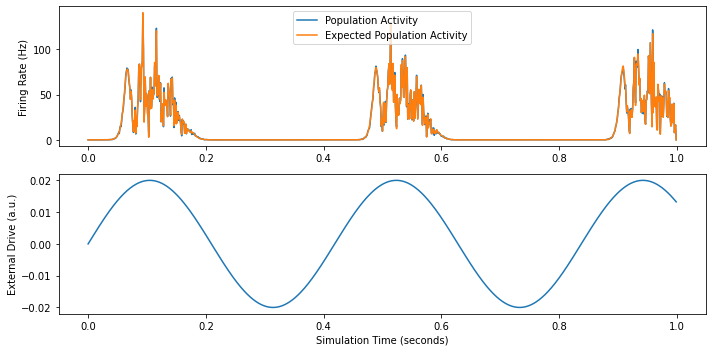

In [33]:
A_avg, A_mean_avg , time_arr  , input_drive = simulation_plotter(coupling_param = 0, num_sim_param = 50, sine = True , freq = 5*3 ) 

# Plot Mesoscopic Activity


plt.rcParams['figure.figsize'] = (10,5)
fig, ax = plt.subplots(2,1 )

ax[0].plot(time_arr , A_avg[1:],   label = 'Population Activity')



ax[0].plot(time_arr ,  A_mean_avg[1:],    label = 'Expected Population Activity')
ax[0].set_ylabel('Firing Rate (Hz)')


ax[0].legend()

ax[1].plot(time_arr, input_drive)
ax[1].set_ylabel('External Drive (a.u.)')
ax[1].set_xlabel('Simulation Time (seconds)')
plt.tight_layout()
plt.show()



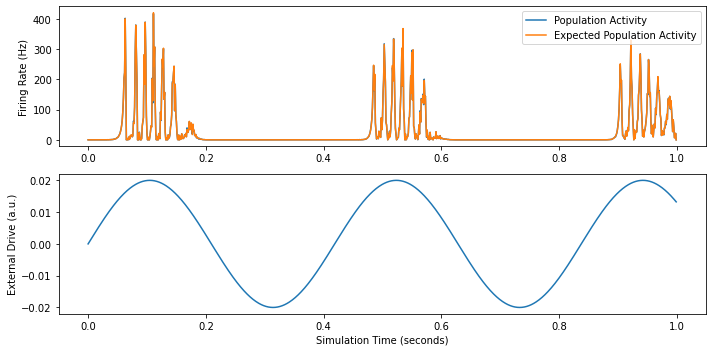

In [35]:
A_avg, A_mean_avg , time_arr  , input_drive = simulation_plotter(coupling_param = 0.005, num_sim_param = 50, sine = True , freq = 5*3 ) 

# Plot Mesoscopic Activity


plt.rcParams['figure.figsize'] = (10,5)
fig, ax = plt.subplots(2,1 )

ax[0].plot(time_arr , A_avg[1:],   label = 'Population Activity')



ax[0].plot(time_arr ,  A_mean_avg[1:],    label = 'Expected Population Activity')
ax[0].set_ylabel('Firing Rate (Hz)')


ax[0].legend()

ax[1].plot(time_arr, input_drive)
ax[1].set_ylabel('External Drive (a.u.)')
ax[1].set_xlabel('Simulation Time (seconds)')
plt.tight_layout()
plt.show()



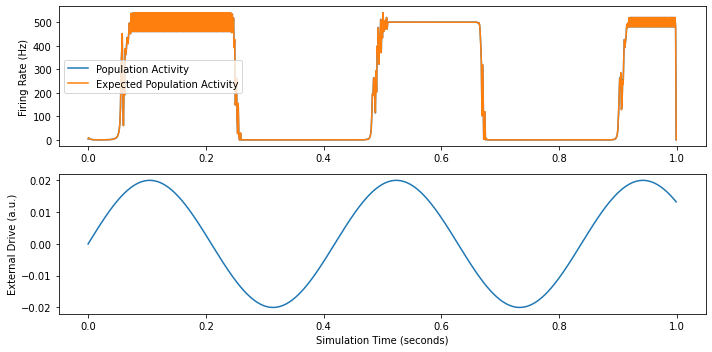

In [36]:
A_avg, A_mean_avg , time_arr  , input_drive = simulation_plotter(coupling_param = 0.01, num_sim_param = 50, sine = True , freq = 5*3 ) 

# Plot Mesoscopic Activity


plt.rcParams['figure.figsize'] = (10,5)
fig, ax = plt.subplots(2,1 )

ax[0].plot(time_arr , A_avg[1:],   label = 'Population Activity')



ax[0].plot(time_arr ,  A_mean_avg[1:],    label = 'Expected Population Activity')
ax[0].set_ylabel('Firing Rate (Hz)')


ax[0].legend()

ax[1].plot(time_arr, input_drive)
ax[1].set_ylabel('External Drive (a.u.)')
ax[1].set_xlabel('Simulation Time (seconds)')
plt.tight_layout()
plt.show()



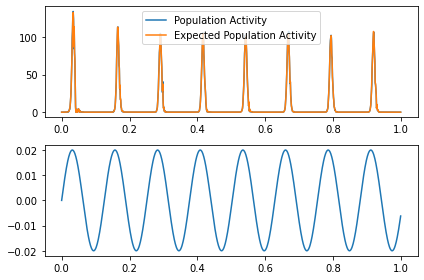

In [ ]:
A_avg, A_mean_avg , time_arr  , input_drive = simulation_plotter(coupling_param = 0, num_sim_param = 50, sine = True , freq = 5*10 ) 

# Plot Mesoscopic Activity

fig, ax = plt.subplots(2,1 )

ax[0].plot(time_arr , A_avg[1:],   label = 'Population Activity')



ax[0].plot(time_arr ,  A_mean_avg[1:],    label = 'Expected Population Activity')


ax[0].legend()

ax[1].plot(time_arr, input_drive)


plt.tight_layout()
plt.show()



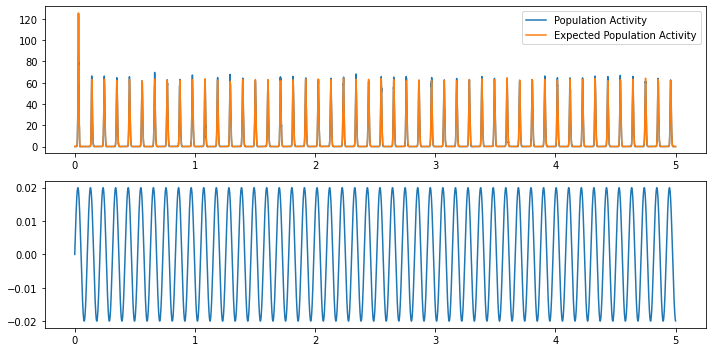

In [39]:
A_avg, A_mean_avg , time_arr  , input_drive = simulation_plotter(coupling_param = 0, num_sim_param = 50, sine = True , freq = 5*12 ,  sim_dur_param = 5. ) 

# Plot Mesoscopic Activity

fig, ax = plt.subplots(2,1 )

ax[0].plot(time_arr , A_avg[1:],   label = 'Population Activity')



ax[0].plot(time_arr ,  A_mean_avg[1:],    label = 'Expected Population Activity')


ax[0].legend()

ax[1].plot(time_arr, input_drive)


plt.tight_layout()
plt.show()



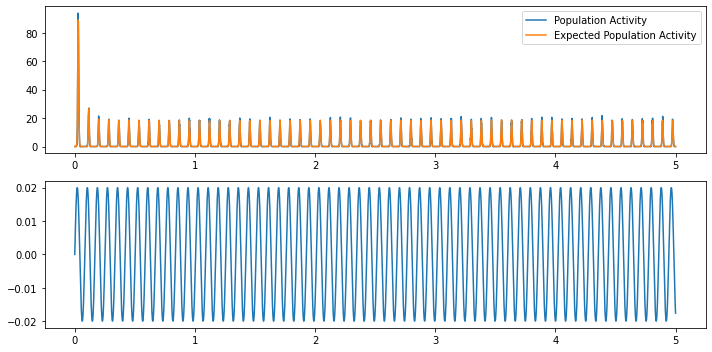

In [40]:
A_avg, A_mean_avg , time_arr  , input_drive = simulation_plotter(coupling_param = 0, num_sim_param = 50, sine = True , freq = 5*15 ,  sim_dur_param = 5. ) 

# Plot Mesoscopic Activity

fig, ax = plt.subplots(2,1 )

ax[0].plot(time_arr , A_avg[1:],   label = 'Population Activity')



ax[0].plot(time_arr ,  A_mean_avg[1:],    label = 'Expected Population Activity')


ax[0].legend()

ax[1].plot(time_arr, input_drive)


plt.tight_layout()
plt.show()



## $ J < 0 $

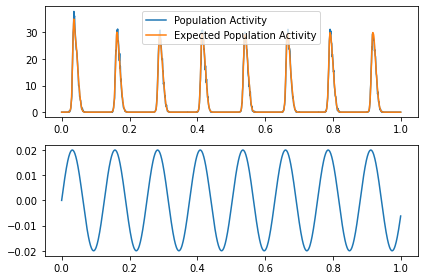

In [ ]:
A_avg, A_mean_avg , time_arr  , input_drive = simulation_plotter(coupling_param = - 0.01 , num_sim_param = 50,  sine = True , freq = 5*10 ) 

# Plot Mesoscopic Activity

fig, ax = plt.subplots(2,1 )

ax[0].plot(time_arr , A_avg[1:],   label = 'Population Activity')



ax[0].plot(time_arr ,  A_mean_avg[1:],    label = 'Expected Population Activity')


ax[0].legend()

ax[1].plot(time_arr, input_drive)


plt.tight_layout()
plt.show()



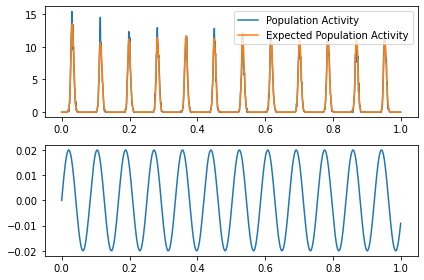

In [ ]:
A_avg, A_mean_avg , time_arr  , input_drive = simulation_plotter(coupling_param = - 0.01 , num_sim_param = 50,  sine = True , freq = 5*15 ) 

# Plot Mesoscopic Activity

fig, ax = plt.subplots(2,1 )

ax[0].plot(time_arr , A_avg[1:],   label = 'Population Activity')



ax[0].plot(time_arr ,  A_mean_avg[1:],    label = 'Expected Population Activity')


ax[0].legend()

ax[1].plot(time_arr, input_drive)


plt.tight_layout()
plt.show()



# Power Spectrum Analysis

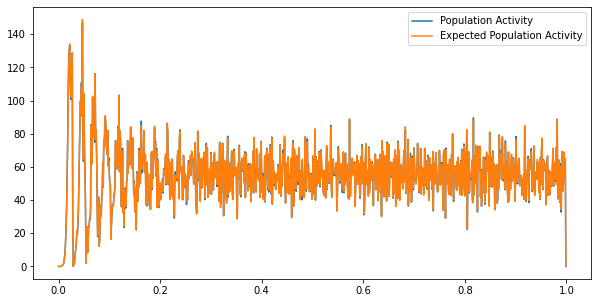

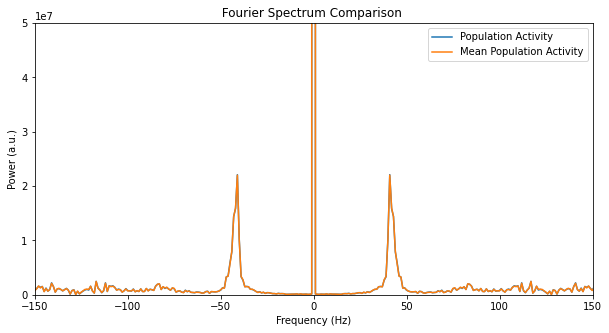

In [49]:
A_avg, A_mean_avg , time_arr , input_drive  = simulation_plotter(coupling_param = 0, num_sim_param = 200) 

# Plot Mesoscopic Activity

plt.plot(time_arr , A_avg[1:],   label = 'Population Activity')
plt.plot(time_arr ,  A_mean_avg[1:],   label = 'Expected Population Activity')
plt.legend()
plt.show() 


ps = np.abs(np.fft.fft(A_avg))**2

time_step = 0.001
freqs = np.fft.fftfreq(A_avg.size, time_step)
idx = np.argsort(freqs)


ps_mean = np.abs(np.fft.fft(A_mean_avg))**2

time_step = 0.001
freqs_mean = np.fft.fftfreq(A_mean_avg.size, time_step)
idx_mean = np.argsort(freqs_mean) 




plt.plot(freqs[idx], ps[idx] , label = 'Population Activity' )
plt.plot(freqs_mean[idx], ps_mean[idx_mean], label = 'Mean Population Activity')
plt.xlim(-150,150)
plt.ylim(-100,0.5*1e8)
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (a.u.)')
plt.title(' Fourier Spectrum Comparison  ')
plt.show()

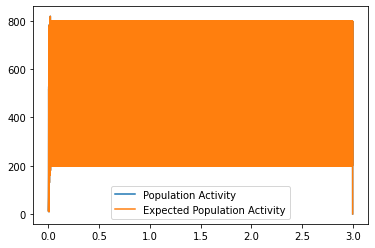

In [10]:
A_avg, A_mean_avg , time_arr , input_drive  = simulation_plotter(coupling_param = 0.01, num_sim_param = 50, sim_dur_param= 3.) 

# Plot Mesoscopic Activity

plt.plot(time_arr , A_avg[1:],   label = 'Population Activity')
plt.plot(time_arr ,  A_mean_avg[1:],   label = 'Expected Population Activity')
plt.legend()
plt.show() 


ps = np.abs(np.fft.fft(A_avg))**2
time_step = 0.001
freqs = np.fft.fftfreq(A_avg.size, time_step)
idx = np.argsort(freqs)


ps_mean = np.abs(np.fft.fft(A_mean_avg))**2

time_step = 0.001
freqs_mean = np.fft.fftfreq(A_mean_avg.size, time_step)
idx_mean = np.argsort(freqs_mean) 





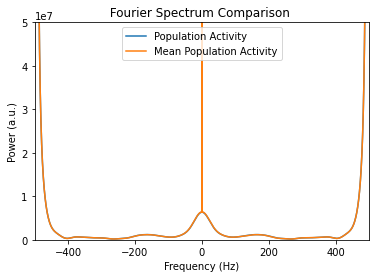

In [14]:

plt.plot(freqs[idx], ps[idx] , label = 'Population Activity' )
plt.plot(freqs_mean[idx], ps_mean[idx_mean], label = 'Mean Population Activity')
plt.xlim(-500,500)
plt.ylim(-100,0.5*1e8)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (a.u.)')
plt.title(' Fourier Spectrum Comparison  ')
plt.legend()
plt.show()

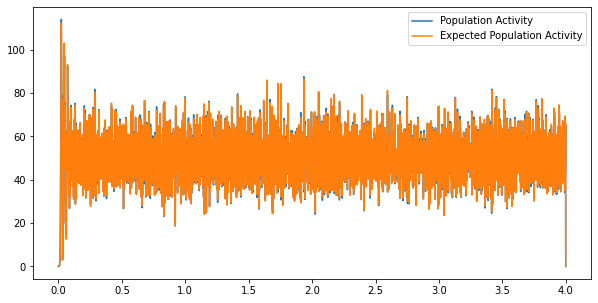

In [50]:
A_avg, A_mean_avg , time_arr , input_drive  = simulation_plotter(coupling_param = -  0.001, num_sim_param = 200, sim_dur_param= 4.) 

# Plot Mesoscopic Activity

plt.plot(time_arr , A_avg[1:],   label = 'Population Activity')
plt.plot(time_arr ,  A_mean_avg[1:],   label = 'Expected Population Activity')
plt.legend()
plt.show() 


ps = np.abs(np.fft.fft(A_avg))**2

time_step = 0.001
freqs = np.fft.fftfreq(A_avg.size, time_step)
idx = np.argsort(freqs)


ps_mean = np.abs(np.fft.fft(A_mean_avg))**2

time_step = 0.001
freqs_mean = np.fft.fftfreq(A_mean_avg.size, time_step)
idx_mean = np.argsort(freqs_mean) 



